In [1]:
import requests as re
import pandas as pd
import numpy as np
import os
import sys
import time
import yfinance as yf
import matplotlib.pyplot as plt
from ast import literal_eval
#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Textblob
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from textblob import TextBlob

#Transformers
from transformers import TextClassificationPipeline

#T5

#Pattern
import pattern

#CoreNLP
import stanza
#RUN THESE ON FIRST TIME
#stanza.install_corenlp()
#stanza.download('en')
from stanza.server import CoreNLPClient

In [2]:
if os.path.isfile('redditcrypto.csv'):
    df = pd.read_csv('redditcrypto.csv')
    df['data'] = df['data'].apply(literal_eval)
else:
    def flatten(input):
        new_list = []
        for i in input:
            if not (isinstance(i, str)):
                for j in i:
                    if len(j) > 0:
                        new_list.append(j.replace('\n', ''))
            else:
                new_list.append(i)
        return new_list

    df = pd.DataFrame()
    while len(df) == 0 or int(df.iloc[-1]['created_utc']) > 1609459200:
        if len(df) == 0:
            r = re.get('https://api.pushshift.io/reddit/search/submission/?subreddit=CryptoCurrency&size=100')
        else:
            r = re.get('https://api.pushshift.io/reddit/search/submission/?subreddit=CryptoCurrency&size=100&before=' + str(int(df.iloc[-1]['created_utc'])))
        if r.status_code == 200:
            r = pd.json_normalize(r.json(), record_path='data')[['author', 'created_utc', 'id', 'is_self', 'link_flair_text', 'num_comments', 'removed_by_category', 'score', 'selftext', 'title', 'url']]
            r = r.where((len(r['selftext']) > 1) & (r['selftext'] != '[removed]') & (r['selftext'] != '[deleted]') & (r['removed_by_category'].isna())).dropna(how='all')
            r['selftext'] = r['selftext'].str.split('.')
            r['data'] = r[['title', 'selftext']].values.tolist()
            r['data'] = r['data'].apply(flatten)
            df = pd.concat([df, r], ignore_index=True)
        else:
            time.sleep(15)
    df.to_csv('redditcrypto.csv')

In [3]:
df

,Unnamed: 0,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,selftext,title,url,data
0,0,2bcompany,1.629395e+09,p7jqgo,0.0,🟢 FINANCE,1.0,NaN,1.0,[''],Wells Fargo And JPMorgan Both File For Passive...,https://bitcoinmagazine.com/business/wells-far...,[Wells Fargo And JPMorgan Both File For Passiv...
1,1,DylBaer,1.629395e+09,p7jqap,0.0,🟢 SECURITY,0.0,NaN,1.0,[''],Japans Liquid Global Exchange Hacked; $90M in ...,https://www.coindesk.com/liquid-hack-japan-bit...,[Japans Liquid Global Exchange Hacked; $90M in...
2,2,DylBaer,1.629395e+09,p7jppc,0.0,🔴 UNRELIABLE SOURCE,2.0,NaN,1.0,[''],JPMorgan Chase reportedly shuts down bank acco...,https://cointelegraph.com/news/jpmorgan-chase-...,[JPMorgan Chase reportedly shuts down bank acc...
3,3,giiga97,1.629395e+09,p7jplq,1.0,EXCHANGE,0.0,NaN,1.0,"[""They are investing a lot of money with these...",Crypto.com aggresive advertising,https://www.reddit.com/r/CryptoCurrency/commen...,"[Crypto.com aggresive advertising, They are in..."
4,4,Purple-Law-1081,1.629395e+09,p7jomv,1.0,NaN,0.0,NaN,1.0,['I reinstalled reddit app and when i logged i...,Urgent Help please!!!!!,https://www.reddit.com/r/CryptoCurrency/commen...,"[Urgent Help please!!!!!, I reinstalled reddit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205888,205888,Alenb123,1.609452e+09,knyzfq,0.0,NaN,4.0,NaN,1.0,[''],I guess I missed out on this one... USD coin u...,https://www.reddit.com/gallery/knyzfq,[I guess I missed out on this one... USD coin ...
205889,205889,Alenb123,1.609452e+09,knyxwe,0.0,NaN,0.0,NaN,1.0,[''],I guess I missed out... USD coin up 3 million ...,https://www.reddit.com/gallery/knyxwe,[I guess I missed out... USD coin up 3 million...
205890,205890,Alenb123,1.609452e+09,knyx4k,0.0,NaN,0.0,NaN,1.0,[''],I guess I missed out on this one... USD coin u...,https://www.reddit.com/gallery/knyx4k,[I guess I missed out on this one... USD coin ...
205891,205891,CryptoPharaoh,1.609452e+09,knywbs,0.0,RELEASE,0.0,NaN,1.0,[''],Stratis InterFlux Release - Bringing Ethereum ...,https://www.stratisplatform.com/2020/12/31/str...,[Stratis InterFlux Release - Bringing Ethereum...


In [3]:
if os.path.isfile('btcprice.csv'):
    btcprices = pd.read_csv('btcprice.csv')
else:
    btcprices = yf.download(tickers="BTC-USD", period="ytd", interval="1h")
    pd.DataFrame(btcprices).to_csv('btcprice.csv')
    pd.DataFrame(btcprices)

In [5]:
#VADER (works.)
analyzer = SentimentIntensityAnalyzer()

def senticol(cols):
    scores = {'neg':[], 'neu':[], 'pos':[], 'compound':[]}
    for i in range(0, len(cols['data'])):
        score = analyzer.polarity_scores(cols['data'][i])
        scores['neg'].append(score['neg'])
        scores['neu'].append(score['neu'])
        scores['pos'].append(score['pos'])
        scores['compound'].append(score['compound'])
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

vader = df
vader[['neg','neu','pos','compound']] = vader.apply(senticol, axis=1)
vader

,Unnamed: 0,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,selftext,title,url,data,neg,neu,pos,compound
0,0,2bcompany,1.629395e+09,p7jqgo,0.0,🟢 FINANCE,1.0,NaN,1.0,[''],Wells Fargo And JPMorgan Both File For Passive...,https://bitcoinmagazine.com/business/wells-far...,[Wells Fargo And JPMorgan Both File For Passiv...,[0.0],[0.678],[0.322],[0.4215]
1,1,DylBaer,1.629395e+09,p7jqap,0.0,🟢 SECURITY,0.0,NaN,1.0,[''],Japans Liquid Global Exchange Hacked; $90M in ...,https://www.coindesk.com/liquid-hack-japan-bit...,[Japans Liquid Global Exchange Hacked; $90M in...,[0.231],[0.769],[0.0],[-0.4019]
2,2,DylBaer,1.629395e+09,p7jppc,0.0,🔴 UNRELIABLE SOURCE,2.0,NaN,1.0,[''],JPMorgan Chase reportedly shuts down bank acco...,https://cointelegraph.com/news/jpmorgan-chase-...,[JPMorgan Chase reportedly shuts down bank acc...,[0.0],[1.0],[0.0],[0.0]
3,3,giiga97,1.629395e+09,p7jplq,1.0,EXCHANGE,0.0,NaN,1.0,"[""They are investing a lot of money with these...",Crypto.com aggresive advertising,https://www.reddit.com/r/CryptoCurrency/commen...,"[Crypto.com aggresive advertising, They are in...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.894, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.0, 0.106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.2263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
4,4,Purple-Law-1081,1.629395e+09,p7jomv,1.0,NaN,0.0,NaN,1.0,['I reinstalled reddit app and when i logged i...,Urgent Help please!!!!!,https://www.reddit.com/r/CryptoCurrency/commen...,"[Urgent Help please!!!!!, I reinstalled reddit...","[0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0]","[0.0, 1.0, 1.0, 1.0, 0.625, 0.711, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.289, 0.0]","[0.7887, 0.0, 0.0, 0.0, -0.34, 0.4291, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205888,205888,Alenb123,1.609452e+09,knyzfq,0.0,NaN,4.0,NaN,1.0,[''],I guess I missed out on this one... USD coin u...,https://www.reddit.com/gallery/knyzfq,[I guess I missed out on this one... USD coin ...,[0.128],[0.872],[0.0],[-0.296]
205889,205889,Alenb123,1.609452e+09,knyxwe,0.0,NaN,0.0,NaN,1.0,[''],I guess I missed out... USD coin up 3 million ...,https://www.reddit.com/gallery/knyxwe,[I guess I missed out... USD coin up 3 million...,[0.155],[0.845],[0.0],[-0.296]
205890,205890,Alenb123,1.609452e+09,knyx4k,0.0,NaN,0.0,NaN,1.0,[''],I guess I missed out on this one... USD coin u...,https://www.reddit.com/gallery/knyx4k,[I guess I missed out on this one... USD coin ...,[0.128],[0.872],[0.0],[-0.296]
205891,205891,CryptoPharaoh,1.609452e+09,knywbs,0.0,RELEASE,0.0,NaN,1.0,[''],Stratis InterFlux Release - Bringing Ethereum ...,https://www.stratisplatform.com/2020/12/31/str...,[Stratis InterFlux Release - Bringing Ethereum...,[0.0],[1.0],[0.0],[0.0]


In [6]:
#Textblob (works.)

def textblobsent(cols):
    scores = {'polarity':[], 'subjectivity':[]}
    for i in range(0, len(cols['data'])):
        sent = TextBlob(cols['data'][i]).sentiment
        scores['polarity'].append(sent.polarity)
        scores['subjectivity'].append(sent.subjectivity)
    return pd.Series([scores['polarity'], scores['subjectivity']])

tb = df
tb[['polarity', 'subjectivity']] = tb.apply(textblobsent, axis=1)
tb

,Unnamed: 0,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,selftext,title,url,data,neg,neu,pos,compound,polarity,subjectivity
0,0,2bcompany,1.629395e+09,p7jqgo,0.0,🟢 FINANCE,1.0,NaN,1.0,[''],Wells Fargo And JPMorgan Both File For Passive...,https://bitcoinmagazine.com/business/wells-far...,[Wells Fargo And JPMorgan Both File For Passiv...,[0.0],[0.678],[0.322],[0.4215],[0.0],[0.0]
1,1,DylBaer,1.629395e+09,p7jqap,0.0,🟢 SECURITY,0.0,NaN,1.0,[''],Japans Liquid Global Exchange Hacked; $90M in ...,https://www.coindesk.com/liquid-hack-japan-bit...,[Japans Liquid Global Exchange Hacked; $90M in...,[0.231],[0.769],[0.0],[-0.4019],[0.0],[0.0]
2,2,DylBaer,1.629395e+09,p7jppc,0.0,🔴 UNRELIABLE SOURCE,2.0,NaN,1.0,[''],JPMorgan Chase reportedly shuts down bank acco...,https://cointelegraph.com/news/jpmorgan-chase-...,[JPMorgan Chase reportedly shuts down bank acc...,[0.0],[1.0],[0.0],[0.0],[-0.1777777777777778],[0.34444444444444444]
3,3,giiga97,1.629395e+09,p7jplq,1.0,EXCHANGE,0.0,NaN,1.0,"[""They are investing a lot of money with these...",Crypto.com aggresive advertising,https://www.reddit.com/r/CryptoCurrency/commen...,"[Crypto.com aggresive advertising, They are in...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.894, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[0.0, 0.106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.2263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.3, 0.0, -0.75, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.1, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,Purple-Law-1081,1.629395e+09,p7jomv,1.0,NaN,0.0,NaN,1.0,['I reinstalled reddit app and when i logged i...,Urgent Help please!!!!!,https://www.reddit.com/r/CryptoCurrency/commen...,"[Urgent Help please!!!!!, I reinstalled reddit...","[0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0]","[0.0, 1.0, 1.0, 1.0, 0.625, 0.711, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.289, 0.0]","[0.7887, 0.0, 0.0, 0.0, -0.34, 0.4291, 0.0]","[0.0, 0.0, 0.1, 0.0, -0.5, 0.0, 0.0]","[0.0, 0.0, 0.2, 0.5, 1.0, 0.4, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205888,205888,Alenb123,1.609452e+09,knyzfq,0.0,NaN,4.0,NaN,1.0,[''],I guess I missed out on this one... USD coin u...,https://www.reddit.com/gallery/knyzfq,[I guess I missed out on this one... USD coin ...,[0.128],[0.872],[0.0],[-0.296],[0.2],[0.3]
205889,205889,Alenb123,1.609452e+09,knyxwe,0.0,NaN,0.0,NaN,1.0,[''],I guess I missed out... USD coin up 3 million ...,https://www.reddit.com/gallery/knyxwe,[I guess I missed out... USD coin up 3 million...,[0.155],[0.845],[0.0],[-0.296],[0.2],[0.3]
205890,205890,Alenb123,1.609452e+09,knyx4k,0.0,NaN,0.0,NaN,1.0,[''],I guess I missed out on this one... USD coin u...,https://www.reddit.com/gallery/knyx4k,[I guess I missed out on this one... USD coin ...,[0.128],[0.872],[0.0],[-0.296],[0.2],[0.3]
205891,205891,CryptoPharaoh,1.609452e+09,knywbs,0.0,RELEASE,0.0,NaN,1.0,[''],Stratis InterFlux Release - Bringing Ethereum ...,https://www.stratisplatform.com/2020/12/31/str...,[Stratis InterFlux Release - Bringing Ethereum...,[0.0],[1.0],[0.0],[0.0],[0.0],[0.0]


In [63]:
btcprices['Unnamed: 0'] = pd.to_datetime(btcprices['Unnamed: 0'], utc=True)
df['created_utc'] = pd.to_datetime(df['created_utc'], utc=True)
df = df.sort_values('created_utc')
btcsent = pd.merge_asof(df, btcprices, left_on='created_utc', right_on='Unnamed: 0', direction='nearest')
btcsent

,Unnamed: 0_x,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,selftext,...,compound,polarity,subjectivity,Unnamed: 0_y,Open,High,Low,Close,Adj Close,Volume
0,205892,Alenb123,2020-12-31 21:53:06+00:00,knyvzp,0.0,NaN,0.0,NaN,1.0,[''],...,[-0.296],[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0
1,205891,CryptoPharaoh,2020-12-31 21:53:40+00:00,knywbs,0.0,RELEASE,0.0,NaN,1.0,[''],...,[0.0],[0.0],[0.0],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0
2,205890,Alenb123,2020-12-31 21:54:55+00:00,knyx4k,0.0,NaN,0.0,NaN,1.0,[''],...,[-0.296],[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0
3,205889,Alenb123,2020-12-31 21:56:15+00:00,knyxwe,0.0,NaN,0.0,NaN,1.0,[''],...,[-0.296],[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0
4,205888,Alenb123,2020-12-31 21:58:50+00:00,knyzfq,0.0,NaN,4.0,NaN,1.0,[''],...,[-0.296],[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205888,4,Purple-Law-1081,2021-08-19 17:40:40+00:00,p7jomv,1.0,NaN,0.0,NaN,1.0,['I reinstalled reddit app and when i logged i...,...,"[0.7887, 0.0, 0.0, 0.0, -0.34, 0.4291, 0.0]","[0.0, 0.0, 0.1, 0.0, -0.5, 0.0, 0.0]","[0.0, 0.0, 0.2, 0.5, 1.0, 0.4, 0.0]",2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456
205889,3,giiga97,2021-08-19 17:42:04+00:00,p7jplq,1.0,EXCHANGE,0.0,NaN,1.0,"[""They are investing a lot of money with these...",...,"[0.0, 0.2263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.3, 0.0, -0.75, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.1, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456
205890,2,DylBaer,2021-08-19 17:42:13+00:00,p7jppc,0.0,🔴 UNRELIABLE SOURCE,2.0,NaN,1.0,[''],...,[0.0],[-0.1777777777777778],[0.34444444444444444],2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456
205891,1,DylBaer,2021-08-19 17:43:02+00:00,p7jqap,0.0,🟢 SECURITY,0.0,NaN,1.0,[''],...,[-0.4019],[0.0],[0.0],2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456


In [3]:
btcsent = pd.read_csv('sentimenttotal.csv')
btcsent['data'] = btcsent['data'].apply(literal_eval)
btcsent['compound'] = btcsent['compound'].apply(literal_eval)
btcsent['polarity'] = btcsent['polarity'].apply(literal_eval)
btcsent['subjectivity'] = btcsent['subjectivity'].apply(literal_eval)
btcsent['raw_data'] = btcsent['data'].str.join('. ')
btcsent

,Unnamed: 0,Unnamed: 0_x,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,...,polarity,subjectivity,Unnamed: 0_y,Open,High,Low,Close,Adj Close,Volume,raw_data
0,0,205892,Alenb123,2020-12-31 21:53:06+00:00,knyvzp,0.0,NaN,0.0,NaN,1.0,...,[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0,I guess I missed out on this one... USD coin u...
1,1,205891,CryptoPharaoh,2020-12-31 21:53:40+00:00,knywbs,0.0,RELEASE,0.0,NaN,1.0,...,[0.0],[0.0],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0,Stratis InterFlux Release - Bringing Ethereum ...
2,2,205890,Alenb123,2020-12-31 21:54:55+00:00,knyx4k,0.0,NaN,0.0,NaN,1.0,...,[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0,I guess I missed out on this one... USD coin u...
3,3,205889,Alenb123,2020-12-31 21:56:15+00:00,knyxwe,0.0,NaN,0.0,NaN,1.0,...,[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0,I guess I missed out... USD coin up 3 million ...
4,4,205888,Alenb123,2020-12-31 21:58:50+00:00,knyzfq,0.0,NaN,4.0,NaN,1.0,...,[0.2],[0.3],2021-01-01 00:00:00+00:00,28994.009766,29033.222656,28803.585938,29032.312500,29032.312500,0,I guess I missed out on this one... USD coin u...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205888,205888,4,Purple-Law-1081,2021-08-19 17:40:40+00:00,p7jomv,1.0,NaN,0.0,NaN,1.0,...,"[0.0, 0.0, 0.1, 0.0, -0.5, 0.0, 0.0]","[0.0, 0.0, 0.2, 0.5, 1.0, 0.4, 0.0]",2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456,Urgent Help please!!!!!. I reinstalled reddit ...
205889,205889,3,giiga97,2021-08-19 17:42:04+00:00,p7jplq,1.0,EXCHANGE,0.0,NaN,1.0,...,"[0.0, 0.3, 0.0, -0.75, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.1, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456,Crypto.com aggresive advertising. They are inv...
205890,205890,2,DylBaer,2021-08-19 17:42:13+00:00,p7jppc,0.0,🔴 UNRELIABLE SOURCE,2.0,NaN,1.0,...,[-0.1777777777777778],[0.34444444444444444],2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456,JPMorgan Chase reportedly shuts down bank acco...
205891,205891,1,DylBaer,2021-08-19 17:43:02+00:00,p7jqap,0.0,🟢 SECURITY,0.0,NaN,1.0,...,[0.0],[0.0],2021-08-19 18:00:00+00:00,45713.937500,46641.968750,45713.937500,46521.984375,46521.984375,1250451456,Japans Liquid Global Exchange Hacked; $90M in ...


In [4]:
def rating_mean(cols):
    return np.array(cols).mean()
btcsent['comp_mean'] = btcsent['compound'].apply(rating_mean)
btcsent['pol_mean'] = btcsent['polarity'].apply(rating_mean)
btcsent['btc_change'] = ((btcsent['Open'] - btcsent['Close']) / btcsent['Open'])
btcsent['is_btc'] = (btcsent['raw_data'].str.lower().str.contains('btc | bitcoin'))
btcsent['is_moon'] = (btcsent['link_flair_text'].str.contains('MOONS')).fillna(False)
btcsent

,Unnamed: 0,Unnamed: 0_x,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,...,Low,Close,Adj Close,Volume,raw_data,comp_mean,pol_mean,btc_change,is_btc,is_moon
0,0,205892,Alenb123,2020-12-31 21:53:06+00:00,knyvzp,0.0,NaN,0.0,NaN,1.0,...,28803.585938,29032.312500,29032.312500,0,I guess I missed out on this one... USD coin u...,-0.296000,0.200000,-0.001321,False,False
1,1,205891,CryptoPharaoh,2020-12-31 21:53:40+00:00,knywbs,0.0,RELEASE,0.0,NaN,1.0,...,28803.585938,29032.312500,29032.312500,0,Stratis InterFlux Release - Bringing Ethereum ...,0.000000,0.000000,-0.001321,False,False
2,2,205890,Alenb123,2020-12-31 21:54:55+00:00,knyx4k,0.0,NaN,0.0,NaN,1.0,...,28803.585938,29032.312500,29032.312500,0,I guess I missed out on this one... USD coin u...,-0.296000,0.200000,-0.001321,False,False
3,3,205889,Alenb123,2020-12-31 21:56:15+00:00,knyxwe,0.0,NaN,0.0,NaN,1.0,...,28803.585938,29032.312500,29032.312500,0,I guess I missed out... USD coin up 3 million ...,-0.296000,0.200000,-0.001321,False,False
4,4,205888,Alenb123,2020-12-31 21:58:50+00:00,knyzfq,0.0,NaN,4.0,NaN,1.0,...,28803.585938,29032.312500,29032.312500,0,I guess I missed out on this one... USD coin u...,-0.296000,0.200000,-0.001321,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205888,205888,4,Purple-Law-1081,2021-08-19 17:40:40+00:00,p7jomv,1.0,NaN,0.0,NaN,1.0,...,45713.937500,46521.984375,46521.984375,1250451456,Urgent Help please!!!!!. I reinstalled reddit ...,0.125400,-0.057143,-0.017676,False,False
205889,205889,3,giiga97,2021-08-19 17:42:04+00:00,p7jplq,1.0,EXCHANGE,0.0,NaN,1.0,...,45713.937500,46521.984375,46521.984375,1250451456,Crypto.com aggresive advertising. They are inv...,0.028659,-0.003659,-0.017676,False,False
205890,205890,2,DylBaer,2021-08-19 17:42:13+00:00,p7jppc,0.0,🔴 UNRELIABLE SOURCE,2.0,NaN,1.0,...,45713.937500,46521.984375,46521.984375,1250451456,JPMorgan Chase reportedly shuts down bank acco...,0.000000,-0.177778,-0.017676,True,False
205891,205891,1,DylBaer,2021-08-19 17:43:02+00:00,p7jqap,0.0,🟢 SECURITY,0.0,NaN,1.0,...,45713.937500,46521.984375,46521.984375,1250451456,Japans Liquid Global Exchange Hacked; $90M in ...,-0.401900,0.000000,-0.017676,False,False


,Unnamed: 0_y,btc_change,comp_mean,pol_mean,date,comp_mean_diff
0,2021-01-01 00:00:00+00:00,-0.001321,0.261667,0.211570,2021-01-01 00:00:00+00:00,NaN
1,2021-01-01 01:00:00+00:00,-0.013220,-0.867100,-1.000000,2021-01-01 00:00:00+00:00,-1.128767
2,2021-01-01 02:00:00+00:00,0.006170,0.361200,0.000000,2021-01-01 00:00:00+00:00,1.228300
3,2021-01-01 03:00:00+00:00,-0.003448,0.185800,-0.049495,2021-01-01 00:00:00+00:00,-0.175400
4,2021-01-01 04:00:00+00:00,0.002609,0.051389,0.019625,2021-01-01 00:00:00+00:00,-0.134411
...,...,...,...,...,...,...
4873,2021-08-19 14:00:00+00:00,-0.009734,0.147423,0.057695,2021-01-16 08:00:00+00:00,0.093470
4874,2021-08-19 15:00:00+00:00,-0.007619,0.230913,0.127442,2021-01-16 08:00:00+00:00,0.083490
4875,2021-08-19 16:00:00+00:00,0.003187,0.108434,0.086343,2021-01-16 08:00:00+00:00,-0.122479
4876,2021-08-19 17:00:00+00:00,-0.001329,0.088931,0.066144,2021-01-16 08:00:00+00:00,-0.019503


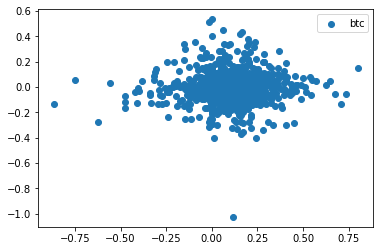

In [44]:
btconly = btcsent.where(btcsent['is_btc'] == True)
plottbl = btconly.groupby('Unnamed: 0_y').mean().reset_index()[['Unnamed: 0_y', 'btc_change', 'comp_mean', 'pol_mean']]
plottbl.to_csv('plottbl.csv')
plottbl['date'] = btcsent['Unnamed: 0_y']
plottbl['comp_mean_diff'] = plottbl['comp_mean'].diff()
display(plottbl)
plt.scatter(plottbl['comp_mean'][:1000], plottbl['btc_change'][:1000]*10, label='btc')
#plt.plot(plottbl['Unnamed: 0_y'][:100], plottbl['comp_mean'][:100], label='VADER')
plt.legend()
plt.show()

In [53]:
plottbl['comp_mean_diff'].corr(plottbl['btc_change'], method='pearson')

0.02211177808027792

In [16]:
#Transformers (Having trouble with long tokens, not sure what to do in those scenarios.)
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

def transsent(cols):
    scores = []
    for i in range(0, len(cols['data'])):
        if (len(cols['data'][i]) > 512):
            rest = len(cols['data'][i])
            proc = 0
            subscore=[]
            while rest > 0:
                subs = cols['data'][i][proc:proc+512]
                sent = classifier(subs)[0]
                if sent['label'] == "NEGATIVE":
                    subscore.append(sent['score'] * -1)
                else:
                    subscore.append(sent['score'])
                proc += 512
                rest -= 512
            scores.append(np.array(subscore).mean())
        else:
            sent = classifier(cols['data'][i])[0]
            if sent['label'] == "NEGATIVE":
                scores.append(sent['score'] * -1)
            else:
                scores.append(sent['score'])
    return pd.Series(scores)

transform = df
transform[['score']] = transform.apply(transsent, axis=1)
transform

KeyboardInterrupt: 

In [ ]:
#T5 (I'll come back to this, this seems more emotion based rather than pos/neg based.)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-emotion")

In [9]:
#Pattern (Uses the same model as textblob.)
from pattern.text.en import sentiment

def pattsent(cols):
    scores = {'polarity':[], 'subjectivity':[]}
    for i in range(0, len(cols['data'])):
        sent = sentiment(cols['data'][i])
        scores['polarity'].append(sent[0])
        scores['subjectivity'].append(sent[1])
    return pd.Series([scores['polarity'], scores['subjectivity']])

patt = df
patt[['polarity2', 'subjectivity2']] = patt.apply(pattsent, axis=1)
patt

,author,created_utc,id,is_self,link_flair_text,num_comments,removed_by_category,score,selftext,title,url,data,neg,neu,pos,compound,polarity,subjectivity,polarity2,subjectivity2
0,Captainwelfare2,1.629321e+09,p70gs9,1.0,SELF-STORY,0.0,NaN,1.0,"[https://www, reddit, com/r/CryptoCurrency/com...","After 17 days of stress and worry, I was able ...",https://www.reddit.com/r/CryptoCurrency/commen...,"[After 17 days of stress and worry, I was able...","[0.279, 0.0, 0.0, 0.061, 0.14]","[0.721, 1.0, 1.0, 0.804, 0.627]","[0.0, 0.0, 0.0, 0.135, 0.233]","[-0.7633, 0.0, 0.0, 0.7701, 0.7112]","[0.34765625, 0.0, 0.0, 0.10416666666666666, 0....","[0.4125, 0.0, 0.0, 0.21979166666666666, 0.5053...","[0.34765625, 0.0, 0.0, 0.10416666666666666, 0....","[0.4125, 0.0, 0.0, 0.21979166666666666, 0.5053..."
1,ItzCaleb_,1.629321e+09,p70g2w,0.0,MEDIA,1.0,NaN,1.0,[],"The ""Father Of Trend Following"" And The Indica...",https://www.newsbtc.com/analysis/btc/trend-fol...,"[The ""Father Of Trend Following"" And The Indic...","[0.0, 0.0]","[1.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.1, 0.0]","[0.0, 0.0]","[0.1, 0.0]"
2,Incorrect_passport,1.629321e+09,p70fnj,1.0,NaN,0.0,NaN,1.0,"[Like the title says, has anyone ever won a de...",Has anyone ever won PancakeSwap Lottery ?,https://www.reddit.com/r/CryptoCurrency/commen...,"[Has anyone ever won PancakeSwap Lottery ?, Li...","[0.0, 0.031, 0.044]","[0.619, 0.826, 0.565]","[0.381, 0.143, 0.39]","[0.5719, 0.6016, 0.9526]","[0.0, 0.23333333333333334, 0.29444444444444445]","[0.0, 0.3833333333333333, 0.43611111111111106]","[0.0, 0.23333333333333334, 0.29444444444444445]","[0.0, 0.3833333333333333, 0.43611111111111106]"
3,VeganMortgageAdviser,1.629321e+09,p70f9y,1.0,SECURITY,0.0,NaN,1.0,"[I know this was only just posted, But as Cha...",Crypto Giveaways,https://www.reddit.com/r/CryptoCurrency/commen...,"[Crypto Giveaways, I know this was only just p...","[0.0, 0.0, 0.0, 0.141, 0.0, 0.156, 0.0]","[1.0, 1.0, 1.0, 0.705, 0.0, 0.602, 1.0]","[0.0, 0.0, 0.0, 0.154, 0.0, 0.242, 0.0]","[0.0, 0.0, 0.0, 0.0516, 0.0, 0.0736, 0.0]","[0.0, 0.0, 0.0, 0.43333333333333335, 0.0, 0.13...","[0.0, 1.0, 0.7, 0.8333333333333334, 0.0, 0.454...","[0.0, 0.0, 0.0, 0.43333333333333335, 0.0, 0.13...","[0.0, 1.0, 0.7, 0.8333333333333334, 0.0, 0.454..."
4,Many_Scratch2269,1.629321e+09,p70exi,1.0,NEW-COIN,0.0,NaN,1.0,"[I've just launched my new coin 5 seconds ago,...",I'm launching my new coin!,https://www.reddit.com/r/CryptoCurrency/commen...,"[I'm launching my new coin!, I've just launche...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.141, 0.0...","[1.0, 0.842, 1.0, 1.0, 1.0, 1.0, 1.0, 0.768, 0...","[0.0, 0.158, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09, 0....","[0.0, 0.128, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2792,...","[0.17045454545454544, 0.13636363636363635, 0.0...","[0.45454545454545453, 0.45454545454545453, 0.0...","[0.17045454545454544, 0.13636363636363635, 0.0...","[0.45454545454545453, 0.45454545454545453, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,ynopro,1.629278e+09,p6nmrm,0.0,GENERAL-NEWS,0.0,NaN,1.0,[],Looking for a dataset that contains informatio...,/r/datasets/comments/p6nmn5/looking_for_a_data...,[Looking for a dataset that contains informati...,"[0.0, 0.0]","[1.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
1045,da_f3nix,1.629278e+09,p6nmr9,1.0,FOCUSED-DISCUSSION,0.0,NaN,1.0,"[I perceive a variation in the Force, , Am I ...",Girl power in the sub!,https://www.reddit.com/r/CryptoCurrency/commen...,"[Girl power in the sub!, I perceive a variatio...","[0.0, 0.0, 0.0, 0.042, 0.0, 0.0]","[1.0, 1.0, 0.0, 0.701, 0.938, 1.0]","[0.0, 0.0, 0.0, 0.257, 0.062, 0.0]","[0.0, 0.0, 0.0, 0.8863, 0.34, 0.0]","[0.0, 0.0, 0.0, 0.35000000000000003, 0.03125, ...","[0.0, 0.0, 0.0, 0.7000000000000001, 0.41666666...","[0.0, 0.0, 0.0, 0.35000000000000003, 0.03125, ...","[0.0, 0.0, 0.0, 0.7000000000000001, 0.41666666..."
1046,dummy_nietzche,1.629278e+09,p6nlpq,0.0,FINANCE,1.0,NaN

In [ ]:
#Stanza (Not working, keeps popping up with long errors and length issues, takes ~5-10 min to run)
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
def stansent(cols):
    scores = []

    for i in range(0, len(cols['data'])):
        try:
            sent = nlp(cols['data'][i]).sentences[0].sentiment
        except:
            sent = 1
        scores.append(sent - 1)
    return scores

stan = df
stan[['score']] = stan.apply(stansent, axis=1)
stan

2021-08-24 16:49:34 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-08-24 16:49:34 INFO: Use device: cpu
2021-08-24 16:49:34 INFO: Loading: tokenize
2021-08-24 16:49:34 INFO: Loading: sentiment
2021-08-24 16:49:34 INFO: Done loading processors!


In [4]:
#CoreNLP (TODO)
client = CoreNLPClient(
    annotators=['sentiment', 'tokenize','ssplit', 'lemma', 'ner', 'pos'],
    memory='8G',
    endpoint='http://localhost:9004',
    be_quiet=True)
print(client)

client.start()

2021-08-24 16:57:18 INFO: Writing properties to tmp file: corenlp_server-9f365499bdf544a0.props
2021-08-24 16:57:18 INFO: Starting server with command: java -Xmx8G -cp C:\Users\tbone\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9004 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9f365499bdf544a0.props -annotators sentiment,tokenize,ssplit,lemma,ner,pos -preload -outputFormat serialized


In [ ]:
def coresent(cols):
    scores = []
    for i in range(0, len(cols['data'])):
        try:
            sent = client.annotate(cols['data'][i])
            if sent.sentence[0].sentiment == 'Neutral':
                scores.append(0)
            elif sent.sentence[0].sentiment == 'Positive':
                scores.append(1)
            elif sent.sentence[0].sentiment == 'Negative':
                scores.append(-1)
        except:
            scores.append(0)
    return scores

core = df
core['cscore'] = core.apply(coresent, axis=1)
core

C:\Users\tbone\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stanza\protobuf\__init__.py:23: RuntimeWarning: Failed to decode a serialized output from CoreNLP server. An incomplete or empty object will be returned.
  warnings.warn("Failed to decode a serialized output from CoreNLP server. An incomplete or empty object will be returned.", \
2021-08-25 00:52:36 INFO: Starting server with command: java -Xmx8G -cp C:\Users\tbone\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9004 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-9f365499bdf544a0.props -annotators sentiment,tokenize,ssplit,lemma,ner,pos -preload -outputFormat serialized


In [ ]:
client.stop()